In [33]:
%load_ext autoreload
%autoreload 2
%run ./initializer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path (/Users/madalenabarcelo/Desktop/BA/DMT) already exists in sys.path


In [34]:
import torch
import torch.nn as nn
import optuna
from sklearn.model_selection import train_test_split
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

from data_loading import DataPreprocessor
from mood_RNN_classifier import RNNClassifier, MoodDataset, OrdinalLabelSmoothingLoss, objective, train_epoch, train_final_model, evaluate, predict, plot_mood_predictions
from torch.utils.data import DataLoader

In [35]:
data_loader = DataPreprocessor()
train_df_split, val_df_split, test_df = data_loader.load_and_preprocess_data("1d", 0.25, 1)

Removed 19 outliers from 968 observations. Percentage: 1.96%


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume train_df and test_df are loaded and preprocessed
id_map = {id_: idx for idx, id_ in enumerate(train_df_split['id'].unique())}
input_dim = train_df_split.drop(columns=['id', 'mood', 'date']).shape[1]
id_count = len(id_map)
output_dim = train_df_split['mood'].max() + 1

In [37]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_df_split, val_df_split, id_map, input_dim, id_count, output_dim, device), n_trials=200)

best_params = study.best_params
print("Best hyperparams:", best_params)

[I 2025-04-18 21:54:55,195] A new study created in memory with name: no-name-aa3cc92f-3618-4e7e-86f6-b551cddd5bda


[I 2025-04-18 21:54:58,414] Trial 0 finished with value: 1.0062267929315567 and parameters: {'hidden_dim': 39, 'id_embed_dim': 13, 'lr': 0.00011155866868459487, 'batch_size': 64, 'alpha': 0.04334097448625169}. Best is trial 0 with value: 1.0062267929315567.
[I 2025-04-18 21:54:59,332] Trial 1 finished with value: 0.49402932077646255 and parameters: {'hidden_dim': 112, 'id_embed_dim': 12, 'lr': 0.007980438635837929, 'batch_size': 64, 'alpha': 0.11333589033414523}. Best is trial 1 with value: 0.49402932077646255.
[I 2025-04-18 21:55:00,199] Trial 2 finished with value: 0.8694843649864197 and parameters: {'hidden_dim': 91, 'id_embed_dim': 10, 'lr': 0.0014486239061415275, 'batch_size': 64, 'alpha': 0.29670884778452816}. Best is trial 1 with value: 0.49402932077646255.
[I 2025-04-18 21:55:01,149] Trial 3 finished with value: 0.8931363970041275 and parameters: {'hidden_dim': 90, 'id_embed_dim': 11, 'lr': 0.0003928195421123301, 'batch_size': 64, 'alpha': 0.13677764935772055}. Best is trial 1 

Best hyperparams: {'hidden_dim': 53, 'id_embed_dim': 11, 'lr': 0.0021048529064153737, 'batch_size': 32, 'alpha': 0.010067935169317262}


In [38]:
# Final model
model = RNNClassifier(
    input_dim=input_dim,
    hidden_dim=best_params['hidden_dim'],
    id_count=id_count,
    id_embed_dim=best_params['id_embed_dim'],
    output_dim=output_dim
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = OrdinalLabelSmoothingLoss(num_classes=output_dim, alpha=best_params['alpha'])

train_loader = DataLoader(MoodDataset(train_df_split, id_map), batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(MoodDataset(val_df_split, id_map), batch_size=best_params['batch_size'])

In [39]:
model = train_final_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=1000)


Epoch 1: train loss = 0.4157, val loss = 0.2816
Epoch 2: train loss = 0.1648, val loss = 0.1170
Epoch 3: train loss = 0.0832, val loss = 0.0801
Epoch 4: train loss = 0.0645, val loss = 0.0684
Epoch 5: train loss = 0.0567, val loss = 0.0629
Epoch 6: train loss = 0.0524, val loss = 0.0591
Epoch 7: train loss = 0.0496, val loss = 0.0562
Epoch 8: train loss = 0.0471, val loss = 0.0548
Epoch 9: train loss = 0.0446, val loss = 0.0543
Epoch 10: train loss = 0.0426, val loss = 0.0525
Epoch 11: train loss = 0.0413, val loss = 0.0540
Epoch 12: train loss = 0.0400, val loss = 0.0516
Epoch 13: train loss = 0.0393, val loss = 0.0537
Epoch 14: train loss = 0.0378, val loss = 0.0530
Epoch 15: train loss = 0.0368, val loss = 0.0537
Epoch 16: train loss = 0.0361, val loss = 0.0530
Epoch 17: train loss = 0.0353, val loss = 0.0548
Epoch 18: train loss = 0.0344, val loss = 0.0542
Epoch 19: train loss = 0.0332, val loss = 0.0547
Epoch 20: train loss = 0.0328, val loss = 0.0559
Epoch 21: train loss = 0.0319

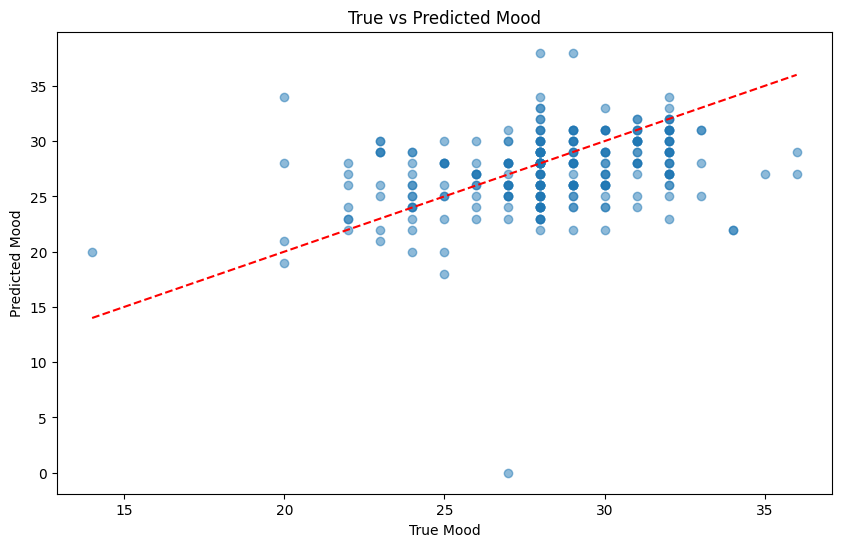

In [40]:
plot_mood_predictions(model, val_loader, device)

In [41]:
from mood_RNN_classifier import get_accuracy_rate
accuracy = get_accuracy_rate(model, val_loader, device)

ImportError: cannot import name 'get_accuracy_rate' from 'mood_RNN_classifier' (/Users/madalenabarcelo/Desktop/BA/DMT/mood_RNN_classifier.py)

In [ ]:
# Run predictions on test_df
test_predictions = predict(model, test_df, id_map, device)

# Attach predictions to test_df
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_mood_class'] = test_predictions

# Optional: save to CSV or examine
print(test_df_with_preds[['id', 'predicted_mood_class']])

         id  predicted_mood_class
0   AS14.01                    28
1   AS14.02                    26
2   AS14.03                    28
3   AS14.05                    27
4   AS14.06                    27
5   AS14.07                    21
6   AS14.08                    25
7   AS14.09                    26
8   AS14.12                    23
9   AS14.13                    34
10  AS14.14                    22
11  AS14.15                    26
12  AS14.16                    27
13  AS14.17                    27
14  AS14.19                    32
15  AS14.20                    20
16  AS14.23                    32
17  AS14.24                    32
18  AS14.25                    26
19  AS14.26                    26
20  AS14.27                    29
21  AS14.28                    30
22  AS14.29                    26
23  AS14.30                    31
24  AS14.31                    29
25  AS14.32                    28
26  AS14.33                    28


In [ ]:
train_df_split = train_df_split.sort_values('mood')
train_df_split['mood'].unique(), train_df_split['mood'].value_counts()

(array([12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
        31, 32, 33, 34, 35, 36, 38], dtype=int32),
 mood
 28    301
 29    138
 32    128
 30    124
 26    103
 27     98
 31     98
 24     66
 25     65
 33     21
 22     17
 23     17
 34     13
 20      7
 35      6
 21      5
 36      4
 14      3
 18      3
 19      2
 15      2
 12      1
 16      1
 38      1
 Name: count, dtype: int64)

In [ ]:
# Random forest
from random_forest_classifier_2a import RandomForestMoodModel 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# 1. Prepare features and labels, filtering rare classes
label_counts = train_df_split['mood'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
train_df_filtered = train_df_split[train_df_split['mood'].isin(valid_labels)]

# Keep date column for evaluation
dates = train_df_filtered['date']

# Then drop id, mood, and date for features
features = train_df_filtered.drop(columns=['id', 'mood', 'date'])
labels = train_df_filtered['mood']

# Train-validation split
X_train, X_val, y_train, y_val, dates_train, dates_val = train_test_split(
    features, labels, dates, test_size=0.2, stratify=labels, random_state=42
)

# 3. Train the classifier with class weights
model = RandomForestMoodModel(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 4. Evaluate on validation set
val_preds = model.predict(X_val)
print("\nValidation Report:")
print(classification_report(y_val, val_preds))

# 5. Predict on test set
X_test = test_df.drop(columns=['id', 'mood', 'date'])
test_preds = model.predict(X_test)

# 6. Attach predictions
test_df_with_preds = test_df.copy()
test_df_with_preds['predicted_mood_class'] = test_preds

# 7. Output predictions
print(test_df_with_preds[['id', 'predicted_mood_class']])



Validation Report:
              precision    recall  f1-score   support

          14       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         3
          23       0.00      0.00      0.00         3
          24       0.08      0.08      0.08        13
          25       0.50      0.08      0.13        13
          26       0.18      0.10      0.12        21
          27       0.00      0.00      0.00        20
          28       0.25      0.65      0.36        60
          29       0.07      0.04      0.05        28
          30       0.07      0.04      0.05        25
          31       0.38      0.15      0.21        20
          32       0.26      0.19      0.22        26
          33       0.00      0.00      0.00         4
          34       0.00      0.00      0.00         3
       

/Users/madalenabarcelo/Desktop/BA/DMT/notebook/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/madalenabarcelo/Desktop/BA/DMT/notebook/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/madalenabarcelo/Desktop/BA/DMT/notebook/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

Daily average RMSE: 1.7376677808372802
Mean Error: 0.09462535014005598


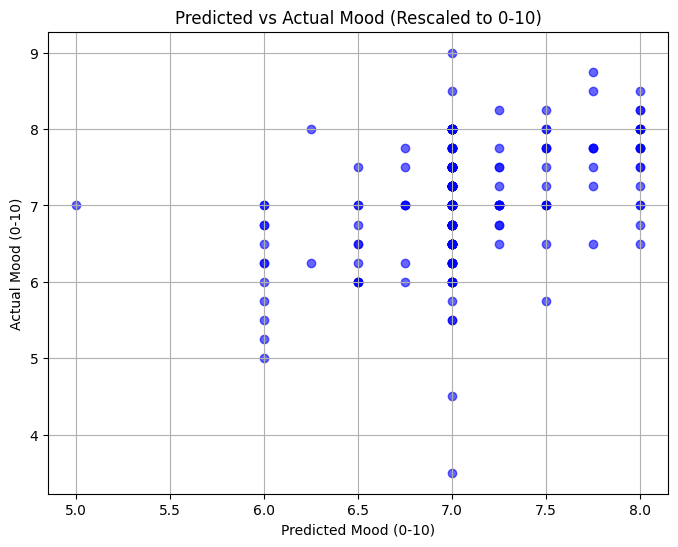

In [ ]:
rmse, mean_error = model.evaluate_daily_average_performance(y_val, val_preds, dates_val)
print("Daily average RMSE:", rmse)
print("Mean Error:", mean_error)

model.plot_predicted_vs_actual(y_val, val_preds)

In [ ]:
# Check class distribution in the training set
print(f"Class distribution in training data:\n{labels.value_counts()}")

Class distribution in training data:
mood
28    301
29    138
32    128
30    124
26    103
27     98
31     98
24     66
25     65
33     21
22     17
23     17
34     13
20      7
35      6
21      5
36      4
18      3
14      3
15      2
19      2
Name: count, dtype: int64


AttributeError: 'RandomForestMoodModel' object has no attribute 'plot_daily_average_predictions'